In [77]:
%pip install pandas
%pip install selenium
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [78]:
import re
import json
import pandas as pd
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
def extract_duration(json_data):
    duration_iso = json_data["duration"]
    duration_seconds = 0

    if duration_iso.startswith("PT"):
        duration_iso = duration_iso[2:]
        hours_index = duration_iso.find("H")
        minutes_index = duration_iso.find("M")
        seconds_index = duration_iso.find("S")

        if hours_index != -1:
            duration_seconds += int(duration_iso[:hours_index]) * 3600
            duration_iso = duration_iso[hours_index + 1 :]

        if minutes_index != -1:
            duration_seconds += int(duration_iso[:minutes_index]) * 60
            duration_iso = duration_iso[minutes_index + 1 :]

        if seconds_index != -1:
            duration_seconds += int(duration_iso[:seconds_index])
    return duration_seconds

def convert_likes(likes_str):
    likes_str = likes_str.upper()
    if " K" in likes_str:
        like_count = float((likes_str).split(" K")[0]) * 1000
    else:
        like_count = float(likes_str)
    return like_count

In [81]:
chromeOptions = webdriver.ChromeOptions()
chromeOptions.add_argument("--headless")

driver = webdriver.Chrome(options=chromeOptions)

In [82]:
PLAYLIST_URL = (
    "https://www.youtube.com/playlist?list=PL7m903CwFUgkUeRB0cGc8WSNNEZ4_zAqe"
)

driver.get(PLAYLIST_URL)

""" 
Con las siguientes líneas de código, lo que hacemos es buscar mediante xpath 
todos los elementos que coincidan con id="video-title", y de los mismos extraemos
el título del video y el link al mismo. 
Estos datos los almacenamos en un diccionario (estructura de datos de tipo clave-valor).
"""
videos_elements = driver.find_elements("xpath", '//*[@id="video-title"]')
videos_tuple = [
    (e.get_attribute("title"), e.get_attribute("href")) for e in videos_elements
]
videos = [
    {"title": e.get_attribute("title"), "link": e.get_attribute("href")}
    for e in videos_elements
]

df_rows = []
for v in videos:
    driver.get(v.get("link"))
    WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="video-title"]'))
    )
    like_button = driver.find_element(
        "xpath",
        '//*[@id="top-level-buttons-computed"]/segmented-like-dislike-button-view-model/yt-smartimation/div/div/like-button-view-model/toggle-button-view-model/button-view-model/button/div[2]',
    )
    views = driver.find_element("xpath", '//*[@id="info"]/span[1]')

    script_element = driver.find_element(
        "xpath", '(//script[@type="application/ld+json"])[2]'
    )
    script_text = script_element.get_attribute("textContent")
    data = json.loads(script_text)

    resource_id = re.search(r"v=([^\&]+)", v.get("link")).group(1)
    like_count = convert_likes(like_button.text)
    duration = extract_duration(data)
    view_count = float(data["interactionCount"])
    video_title = v.get("title")
    df_rows.append([resource_id, view_count, like_count, duration, video_title])

driver.quit()

In [83]:
df_youtube_statistics = pd.DataFrame(
    data=df_rows, 
    columns=["resource_id", "view_count", "like_count", "duration", "title"]
)

In [84]:
df_youtube_statistics.sort_values(
    by="view_count", ascending=False, ignore_index=True, inplace=True
)

In [85]:
df_youtube_statistics

,resource_id,view_count,like_count,duration,title
0,Pfcd0gWNIog,583265.0,30000.0,1768,"Special address by Javier Milei, President of Argentina | Davos 2024 | World Economic Forum"
1,5xS5IoyoGqg,72104.0,500.0,1691,Welcoming Remarks and Special Address | Davos 2024 | World Economic Forum
2,sQaK9PRaa48,62188.0,921.0,2726,"A Conversation with Antony Blinken, United States Secretary of State | Davos 2024 | WEF"
3,zDGP3FX1YHA,55724.0,1600.0,2096,"A Conversation with Pham Minh Chinh, Prime Minister of Viet Nam | Davos 2024 | World Economic Forum"
4,VXtVb4WWwUg,48524.0,585.0,1740,"Special Address by Ursula von der Leyen, President of the European Commission | Davos 2024"
5,ZkyVWENhjY4,32090.0,456.0,2710,"A Special Address by Jake Sullivan, United States National Security Advisor | Davos 2024"
6,3XEePuWki9s,26303.0,396.0,3760,"Special Address by Emmanuel Macron, President of France | Davos 2024 | World Economic Forum"
7,1_paj2xzgGE,19939.0,445.0,2198,"Special Address by Volodymyr Zelenskyy, President of Ukraine | Davos 2024 | World Economic Forum"
8,9h1qZdXgb7Q,13371.0,216.0,2158,"Special Address by Pedro Sánchez, Prime Minister of Spain | Davos 2024 | World Economic Forum"
9,JqM_9OAUHEU,11575.0,190.0,2767,"A Conversation with Isaac Herzog, President of Israel | Davos 2024 | World Economic Forum"


In [86]:
df_youtube_statistics = df_youtube_statistics.copy()
df_youtube_statistics["likes_ratio"] = round((df_youtube_statistics["like_count"] / df_youtube_statistics["view_count"]) * 100, 2)
df_youtube_statistics["title"] = df_youtube_statistics["title"].apply(lambda x: x.split("|")[0])
df_youtube_statistics.sort_values(by="likes_ratio", ascending=False, inplace=True)
df_youtube_statistics

,resource_id,view_count,like_count,duration,title,likes_ratio
0,Pfcd0gWNIog,583265.0,30000.0,1768,"Special address by Javier Milei, President of Argentina",5.14
3,zDGP3FX1YHA,55724.0,1600.0,2096,"A Conversation with Pham Minh Chinh, Prime Minister of Viet Nam",2.87
13,6e0zeBVaDKw,5683.0,151.0,2417,"A Conversation With Mohammed Shyaa Al Sudani, Prime Minister of Iraq",2.66
7,1_paj2xzgGE,19939.0,445.0,2198,"Special Address by Volodymyr Zelenskyy, President of Ukraine",2.23
9,JqM_9OAUHEU,11575.0,190.0,2767,"A Conversation with Isaac Herzog, President of Israel",1.64
8,9h1qZdXgb7Q,13371.0,216.0,2158,"Special Address by Pedro Sánchez, Prime Minister of Spain",1.62
12,ceESHIoIIcg,7061.0,109.0,2081,"A Conversation with Kyriakos Mitsotakis, Prime Minister of Greece",1.54
6,3XEePuWki9s,26303.0,396.0,3760,"Special Address by Emmanuel Macron, President of France",1.51
2,sQaK9PRaa48,62188.0,921.0,2726,"A Conversation with Antony Blinken, United States Secretary of State",1.48
5,ZkyVWENhjY4,32090.0,456.0,2710,"A Special Address by Jake Sullivan, United States National Security Advisor",1.42


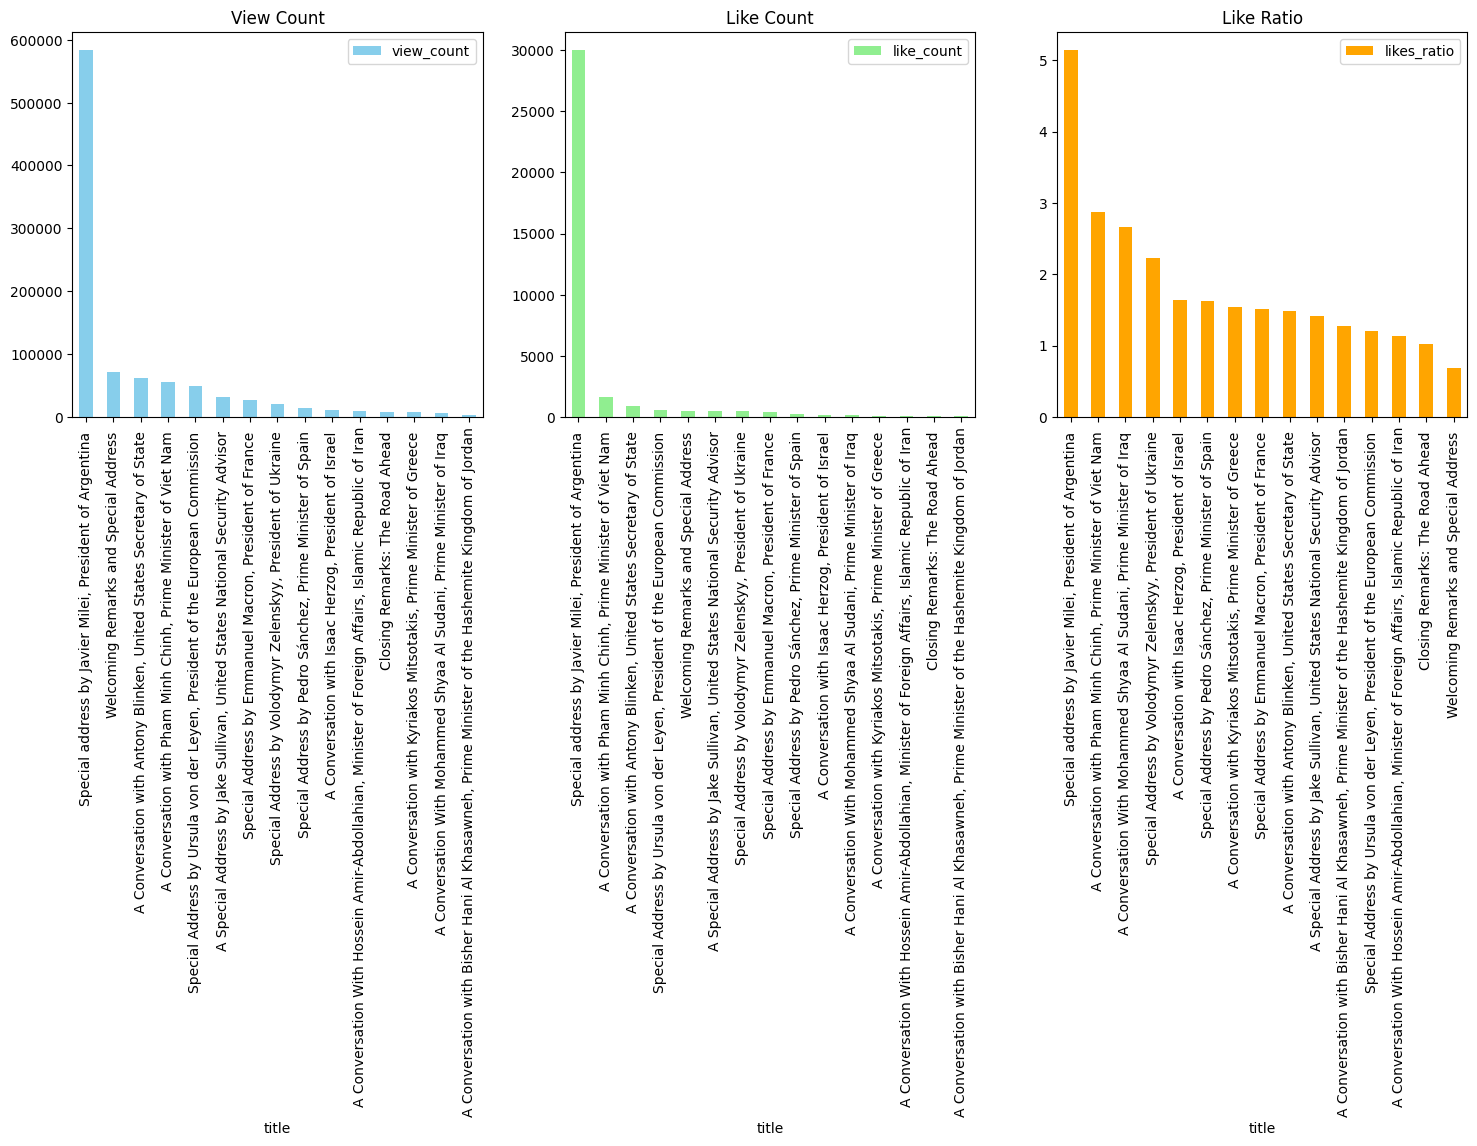

In [87]:
df_youtube_sorted_by_views = df_youtube_statistics.sort_values(by='view_count', ascending=False)
df_youtube_sorted_by_likes = df_youtube_statistics.sort_values(by='like_count', ascending=False)
df_youtube_sorted_by_ratio = df_youtube_statistics.sort_values(by='likes_ratio', ascending=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

df_youtube_sorted_by_views.plot.bar(x="title", y="view_count", ax=axs[0], color='skyblue')
axs[0].set_title('View Count')

df_youtube_sorted_by_likes.plot.bar(x="title", y="like_count", ax=axs[1], color='lightgreen')
axs[1].set_title('Like Count')

df_youtube_sorted_by_ratio.plot.bar(x="title", y="likes_ratio", ax=axs[2], color='orange')
axs[2].set_title('Like Ratio')

plt.tight_layout()

plt.savefig('youtube_statistics.png')

plt.show()